In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *

In [99]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cpu


In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [4]:
# Get IDs
try:
    ids = next(os.walk(PATH))[1]
    #print(ids)
except StopIteration:
    pass # Some error handling here

#print("HERE")

# Get and resize images and masks
X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype= np.float32)
Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype= np.float32)
#print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path = PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
#print('Done!')


100%|██████████| 670/670 [01:25<00:00,  7.80it/s]


Shape of X_train =  (402, 128, 128, 3)
Shape of Y_train =  (402, 128, 128, 1)
Shape of X_val =  (134, 128, 128, 3)
Shape of Y_val =  (134, 128, 128, 1)
Shape of X_test =  (134, 128, 128, 3)
Shape of Y_test =  (134, 128, 128, 1)


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


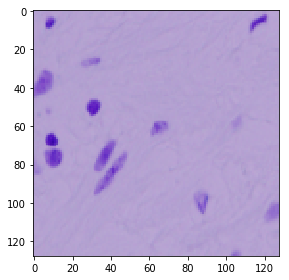

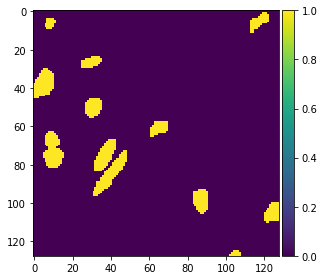

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [64]:
# Splitting data into train/val/test set in a 60/20/20 split
shuffled_indices = np.random.permutation(len(X))

train_indices = shuffled_indices[0:int(.6*(len(X)))]
val_indices = shuffled_indices[int(.6*(len(X))): int(.8*(len(X)))]
test_indices = shuffled_indices[int(.8*(len(X))):]

X_train = X[train_indices]
Y_train = Y[train_indices]
Y_train[Y_train.nonzero()] = 1
X_val = X[val_indices]
Y_val = Y[val_indices]
Y_val[Y_val.nonzero()] = 1
X_test = X[test_indices]
Y_test = Y[test_indices]
Y_test[Y_test.nonzero()] = 1

# Let us visualize what inputs outputs look like
randIndex = random.randint(0, len(X_train))
imshow(np.uint8(X_train[randIndex]))
plt.show()
imshow(np.squeeze(np.uint8(Y_train[randIndex])))
plt.show()

X_train = np.transpose(X_train, (0,3,1,2))
Y_train = np.transpose(Y_train, (0,3,1,2))
X_val = np.transpose(X_val, (0,3,1,2))
Y_val = np.transpose(Y_val, (0,3,1,2))
X_test = np.transpose(X_test, (0,3,1,2))
Y_test = np.transpose(Y_test, (0,3,1,2))

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

In [74]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [36]:
def calc_iou(preds, y):
    preds = preds.view(preds.shape[0], -1)
    y = y.view(y.shape[0], -1)
    intersection = y.take(preds.nonzero()).sum()
    union = y.sum() + (preds.type(torch.float)).sum() - intersection
    return (intersection/(union + epsilon))

In [84]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64,visual = False):
    model.eval() #set model to evaluation mode
    mean_iou = 0
    num_batches = int(len(X_perf)/mini_batch_size)
    num_remaining = len(X_perf) - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            x = x.to(device = device, dtype = dtype)
            y = y.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5)
            mean_iou += float(mini_batch_size)*calc_iou(preds, y)
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :])
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5)
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), len(X_perf))
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].numpy())
        mean_iou += float(num_remaining)*calc_iou(preds, y)
    return (mean_iou/(float(len(X_perf))))

In [92]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
            if (num_remaining <= 0 and t == (num_batches -1)):
                iou = calculatePerformance(x_train, y_train, model)
                print('Train Mean IOU at epoch %d is %.4f' % (e, iou))
                if (noVal == False):
                    iou = calculatePerformance(X_val, Y_val, model)
                    print('Val Mean IOU at epoch %d is %.4f' % (e, iou))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                    print('Epoch %d, Iteration %d, loss = %.4f' % (e, 6, loss.item()))
            iou = calculatePerformance(x_train, y_train, model)
            print('Train Mean IOU at epoch %d is %.4f' % (e, iou))
            if (noVal == False):
                iou = calculatePerformance(X_val, Y_val, model)
                print('Val Mean IOU at epoch %d is %.4f' % (e, iou))
            T +=1
    return calculatePerformance(x_train, y_train, model)

In [110]:
# Overfitting data first
bestPerf = -1
bestModel = None
lrUsed = 0
x_train = X_train[0:31, :, :, :]
y_train = Y_train[0:31, :, :, :]
for lr in [1e-3, 1e-4]:
    print('Trying out learning rate of ', lr)
    model = UNet()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf = trainModel(model, x_train, y_train, optimizer, epochs = 40, noVal = True)
    if modelPerf > bestPerf:
        bestPerf = modelPerf
        bestModel = model
        lrUsed = lr

Trying out learning rate of  0.001
Epoch 0, Iteration 6, loss = 3.9132
Train Mean IOU at epoch 0 is 0.0422
Epoch 1, Iteration 6, loss = 3.5868
Train Mean IOU at epoch 1 is 0.0969
Epoch 2, Iteration 6, loss = 3.4692
Train Mean IOU at epoch 2 is 0.0873
Epoch 3, Iteration 6, loss = 2.1791
Train Mean IOU at epoch 3 is 0.0898
Epoch 4, Iteration 6, loss = 1.8597
Train Mean IOU at epoch 4 is 0.1079
Epoch 5, Iteration 6, loss = 1.6980
Train Mean IOU at epoch 5 is 0.1184
Epoch 6, Iteration 6, loss = 1.4930
Train Mean IOU at epoch 6 is 0.1453
Epoch 7, Iteration 6, loss = 1.9970
Train Mean IOU at epoch 7 is 0.1062
Epoch 8, Iteration 6, loss = 1.8870
Train Mean IOU at epoch 8 is 0.0901
Epoch 9, Iteration 6, loss = 1.4404
Train Mean IOU at epoch 9 is 0.0922
Epoch 10, Iteration 6, loss = 1.3340
Train Mean IOU at epoch 10 is 0.1045
Epoch 11, Iteration 6, loss = 1.5039
Train Mean IOU at epoch 11 is 0.1294
Epoch 12, Iteration 6, loss = 1.8435
Train Mean IOU at epoch 12 is 0.1472
Epoch 13, Iteration 6, 

Best learning rate used to train was  0.001


/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


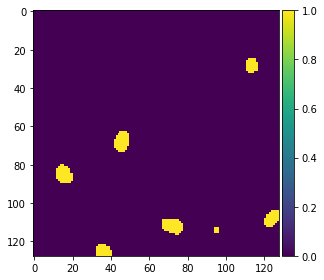

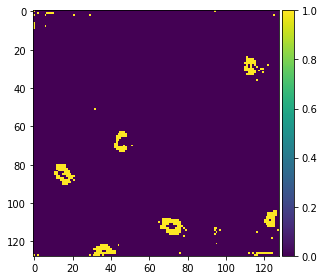

Best train IOU =  tensor(0.1400)


In [117]:
# Let us visualize how different our predicted masks are
print('Best learning rate used to train was ', lrUsed)
print('Best train IOU = ', calculatePerformance(x_train, y_train, bestModel, visual = True))